In [66]:
import seaborn as sns
import pandas as pd
import numpy as np
import altair as alt
from markdown import markdown
from IPython.display import Markdown
from ipywidgets.widgets import HTML, Tab
from ipywidgets import widgets
from datetime import timedelta
from matplotlib import pyplot as plt
import os.path as op

from mod import load_data, alt_theme

In [67]:
def author_url(author):
    return f"https://github.com/{author}"

In [68]:
# Parameters
fmt_date = "{:%Y-%m-%d}"

n_days = 90
start_date = fmt_date.format(pd.datetime.today() - timedelta(days=n_days))
end_date = fmt_date.format(pd.datetime.today())

renderer = "jupyterlab"
github_orgs = ["jupyterhub", "jupyter", "jupyterlab", "jupyter-widgets", "ipython", "binder-examples", "nteract"]

In [75]:
comments, issues, prs = load_data('../data/')
bot_names = pd.read_csv('bot_names.csv')['names'].tolist()
comments = comments.query('author not in @bot_names').drop_duplicates()
issues = issues.query('author not in @bot_names').drop_duplicates()
prs = prs.query('author not in @bot_names').drop_duplicates()

/c/Users/chold/Dropbox/projects/jupyter-activity-snapshot/templates/mod/__init__.py:24: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/c/Users/chold/Dropbox/projects/jupyter-activity-snapshot/templates/mod/__init__.py:25: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/c/Users/chold/Dropbox/projects/jupyter-activity-snapshot/templates/mod/__init__.py:26: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current beha

In [74]:
# Only keep the datapoints we want
query_data = 'updatedAt > @start_date and updatedAt < @end_date and org in @github_orgs'
comments = comments.query(query_data)
issues = issues.query(query_data)
prs = prs.query(query_data)

In [71]:
alt.renderers.enable(renderer);
alt.themes.register('my_theme', alt_theme)
alt.themes.enable("my_theme")

ThemeRegistry.enable('my_theme')

In [72]:
# Information about out time window
time_delta = pd.to_datetime(end_date) - pd.to_datetime(start_date)
n_days = time_delta.days

# Information about the data we loaded
github_orgs = comments['org'].unique()

# GitHub activity

Jupyter also has lots of activity across GitHub repositories. The following sections contain
overviews of recent activity across the following GitHub organizations:

In [52]:
# Define colors we'll use for GitHub membership
author_types = ['MEMBER', 'CONTRIBUTOR', 'COLLABORATOR', "NONE"]

author_palette = sns.palettes.blend_palette(["lightgrey", "lightgreen", "darkgreen"], 4)
author_colors = ["rgb({}, {}, {}, {})".format(*(ii*256)) for ii in author_palette]
author_color_dict = {key: val for key, val in zip(author_types, author_palette)}

In [53]:
orgs_md = []
for org in github_orgs:
    orgs_md.append(f'* [github.com/{org}](https://github.com/{org})')
Markdown('\n'.join(orgs_md))

* [github.com/jupyterlab](https://github.com/jupyterlab)
* [github.com/jupyter-widgets](https://github.com/jupyter-widgets)
* [github.com/ipython](https://github.com/ipython)
* [github.com/binder-examples](https://github.com/binder-examples)
* [github.com/jupyter](https://github.com/jupyter)
* [github.com/jupyterhub](https://github.com/jupyterhub)
* [github.com/nteract](https://github.com/nteract)

In [54]:
Markdown(f"Showing GitHub activity from **{start_date}** to **{end_date}**")

Showing GitHub activity from **2019-05-22** to **2019-08-20**

## List of all contributors per organization

First, we'll list each contributor that has contributed to each organization in the last several days.
Contributions to open source projects are diverse, and involve much more than just contributing code and
code review. Thanks to everybody in the Jupyter communities for all that they do.

In [55]:
n_plot = 5
tabs = widgets.Tab(children=[])
for ii, org in enumerate(github_orgs):
    authors_comments = comments.query('org == @org')['author']
    authors_prs = prs.query('org == @org')['author']
    unique_participants = np.unique(np.hstack([authors_comments.values, authors_prs.values]).astype(str)).tolist()
    unique_participants.sort(key=lambda a: a.lower())
    
    all_participants = [f"[{participant}](https://github.com/{participant})" for participant in unique_participants]
    participants_md = " | ".join(all_participants)
    md_html = HTML("<center>{}</center>".format(markdown(participants_md)))
    
    children = list(tabs.children)
    children.append(md_html)
    tabs.children = tuple(children)
    tabs.set_title(ii, org)
    
display(Markdown(f"All participants across issues and pull requests in each org in the last {n_days} days"))
display(tabs)

All participants across issues and pull requests in each org in the last 90 days

## Merged Pull requests

Here's an analysis of **merged pull requests** across each of the repositories in the Jupyter
ecosystem.

In [56]:
merged = prs.query('state == "MERGED" and closedAt > @start_date and closedAt < @end_date')

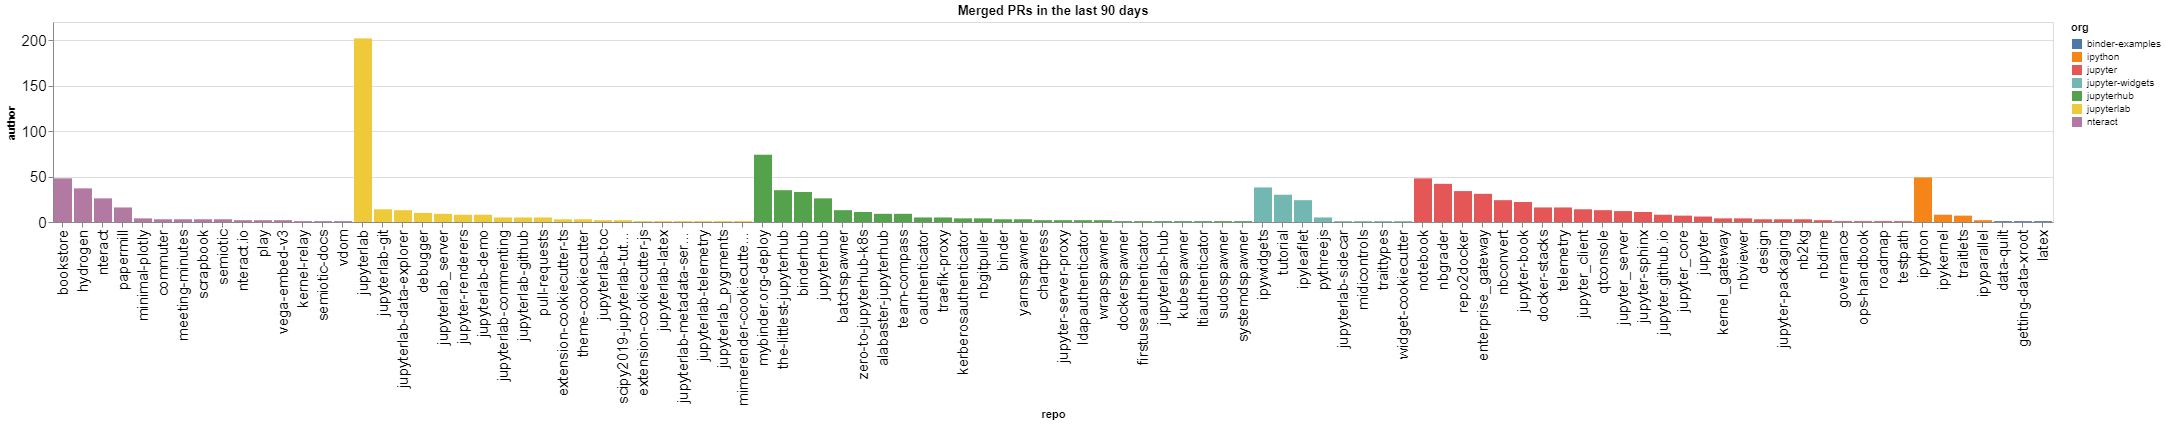

In [57]:
prs_by_repo = merged.groupby(['org', 'repo']).count()['author'].reset_index().sort_values(['org', 'author'], ascending=False)
alt.Chart(data=prs_by_repo, title=f"Merged PRs in the last {n_days} days").mark_bar().encode(
    x=alt.X('repo', sort=prs_by_repo['repo'].values.tolist()),
    y='author',
    color='org'
)

### A list of merged PRs by project

Below is a tabbed readout of recently-merged PRs. Check out the title to get an idea for what they
implemented, and be sure to thank the PR author for their hard work!

In [58]:
tabs = widgets.Tab(children=[])
merged_by = {}
pr_by = {}
for ii, (org, idata) in enumerate(merged.groupby('org')):
    issue_md = []
    issue_md.append(f"#### Closed PRs for org: `{org}`")
    issue_md.append("")
    for (org, repo), prs in idata.groupby(['org', 'repo']):
        issue_md.append(f"##### [{org}/{repo}](https://github.com/{org}/{repo})")
        for _, pr in prs.iterrows():
            user_name = pr['author']
            user_url = author_url(user_name)
            pr_number = pr['number']
            pr_html = pr['url']
            pr_title = pr['title']
            pr_closedby = pr['mergedBy']
            pr_closedby_url = f"https://github.com/{pr_closedby}"
            if user_name not in pr_by:
                pr_by[user_name] = 1
            else:
                pr_by[user_name] += 1
                
            if pr_closedby not in merged_by:
                merged_by[pr_closedby] = 1
            else:
                merged_by[pr_closedby] += 1
            text = f"* [(#{pr_number})]({pr_html}): _{pr_title}_ by **[@{user_name}]({user_url})** merged by **[@{pr_closedby}]({pr_closedby_url})**"
            issue_md.append(text)
    issue_md.append('')
    markdown_html = markdown('\n'.join(issue_md))
    
    children = list(tabs.children)
    children.append(HTML(markdown_html))
    tabs.children = tuple(children)
    tabs.set_title(ii, org)
tabs

### Authoring and merging stats by repository

Let's see who has been doing most of the PR authoring and merging. The PR author is generally the
person that implemented a change in the repository (code, documentation, etc). The PR merger is
the person that "pressed the green button" and got the change into the main codebase.

In [59]:
# Prep our merging DF
merged_by_repo = merged.groupby(['org', 'repo', 'author'], as_index=False).agg({'id': 'count', 'authorAssociation': 'first'}).rename(columns={'id': "authored", 'author': 'username'})
closed_by_repo = merged.groupby(['org', 'repo', 'mergedBy']).count()['id'].reset_index().rename(columns={'id': "closed", "mergedBy": "username"})

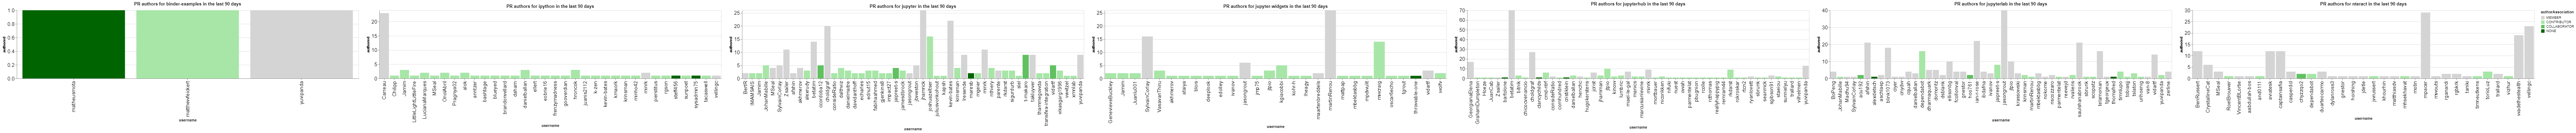

In [60]:
n_plot = 50
charts = []
for ii, (iorg, idata) in enumerate(merged_by_repo.replace(np.nan, 0).groupby(['org'])):
    title = f"PR authors for {iorg} in the last {n_days} days"
    idata = idata.groupby('username', as_index=False).agg({'authored': 'sum', 'authorAssociation': 'first'})
    idata = idata.sort_values('authored', ascending=False).head(n_plot)
    ch = alt.Chart(data=idata, width=1000, title=title).mark_bar().encode(
        x='username',
        y='authored',
        color=alt.Color('authorAssociation', scale=alt.Scale(domain=author_types, range=author_colors))
    )
    charts.append(ch)

alt.hconcat(*charts)

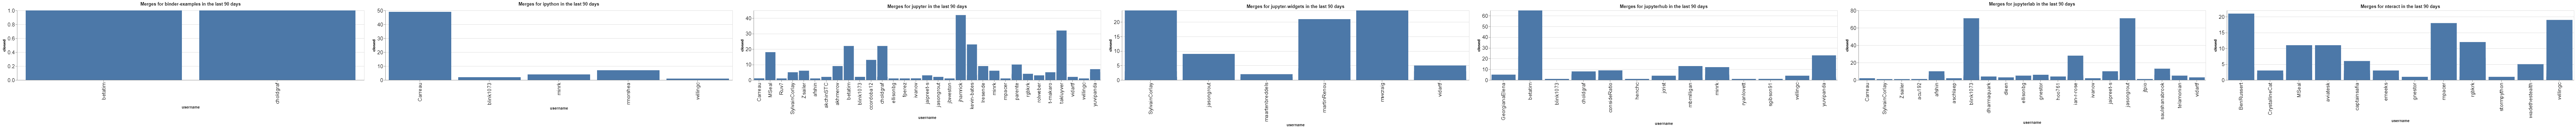

In [61]:
charts = []
for ii, (iorg, idata) in enumerate(closed_by_repo.replace(np.nan, 0).groupby(['org'])):
    title = f"Merges for {iorg} in the last {n_days} days"
    ch = alt.Chart(data=idata, width=1000, title=title).mark_bar().encode(
        x='username',
        y='closed',
    )
    charts.append(ch)
alt.hconcat(*charts)

## Issues

Issues are **conversations** that happen on our GitHub repositories. Here's an
analysis of issues across the Jupyter organizations.

In [62]:
created = issues.query('state == "OPEN" and createdAt > @start_date and createdAt < @end_date')
closed = issues.query('state == "CLOSED" and closedAt > @start_date and closedAt < @end_date')

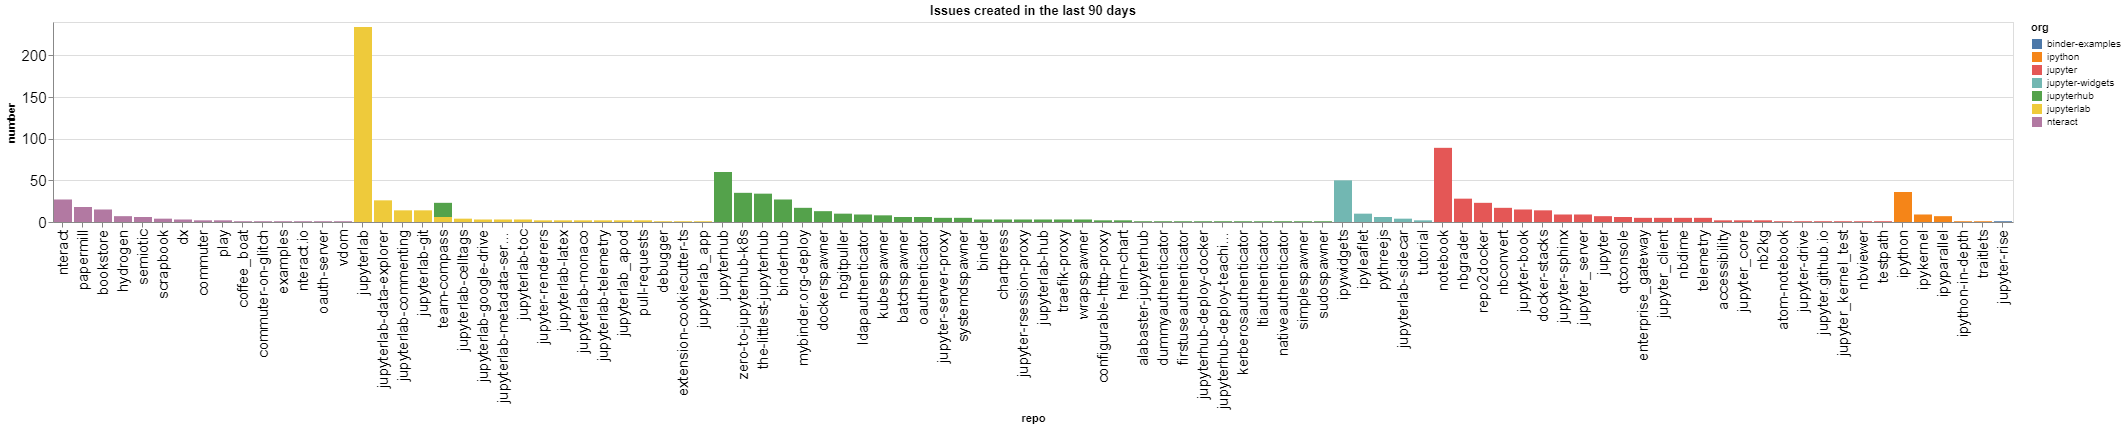

In [63]:
created_counts = created.groupby(['org', 'repo']).count()['number'].reset_index()
created_counts['org/repo'] = created_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = created_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=created_counts, title=f"Issues created in the last {n_days} days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

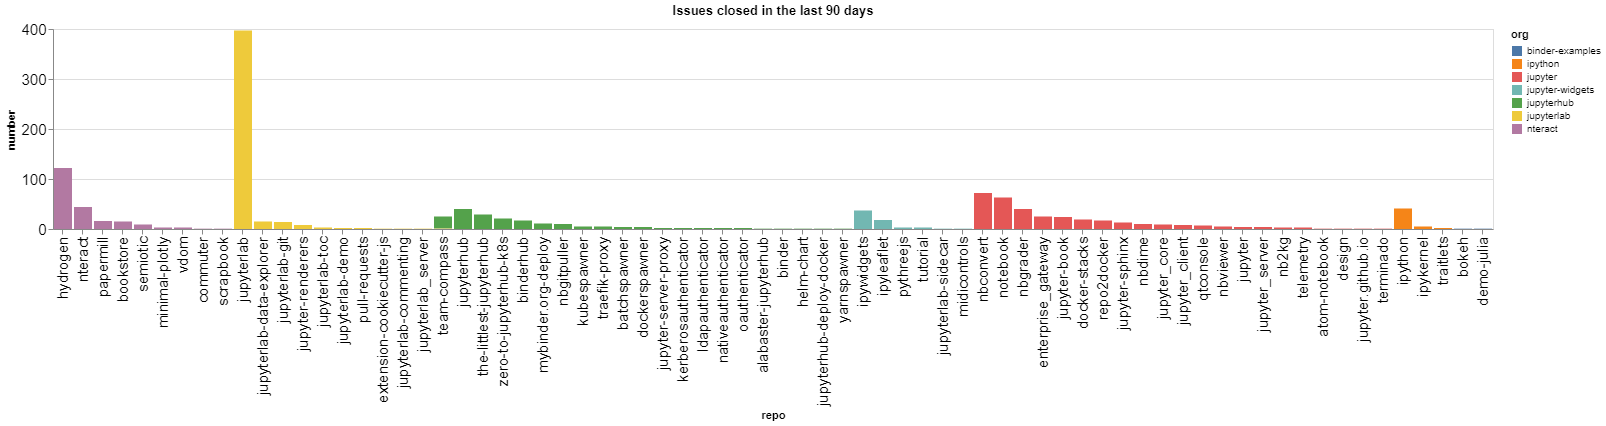

In [64]:
closed_counts = closed.groupby(['org', 'repo']).count()['number'].reset_index()
closed_counts['org/repo'] = closed_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = closed_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=closed_counts, title=f"Issues closed in the last {n_days} days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

In [65]:
created_closed = pd.merge(created_counts.rename(columns={'number': 'created'}).drop(columns='org/repo'),
                          closed_counts.rename(columns={'number': 'closed'}).drop(columns='org/repo'),
                          on=['org', 'repo'], how='outer')

created_closed = pd.melt(created_closed, id_vars=['org', 'repo'], var_name="kind", value_name="count").replace(np.nan, 0)

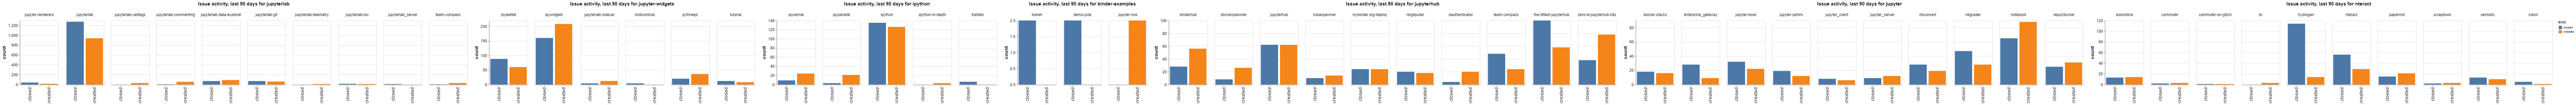

In [22]:
charts = []
for org in github_orgs:
    # Pick the top 10 repositories
    this_issues = created_closed.query('org == @org')
    top_repos = this_issues.groupby(['repo']).sum().sort_values(by='count', ascending=False).head(10).index
    ch = alt.Chart(this_issues.query('repo in @top_repos'), width=120).mark_bar().encode(
        x=alt.X("kind", axis=alt.Axis(labelFontSize=15, title="")), 
        y=alt.Y('count', axis=alt.Axis(titleFontSize=15, labelFontSize=12)),
        color='kind',
        column=alt.Column("repo", header=alt.Header(title=f"Issue activity, last {n_days} days for {org}", titleFontSize=15, labelFontSize=12))
    )
    charts.append(ch)
alt.hconcat(*charts)

In [23]:
# Set to datetime
for kind in ['createdAt', 'closedAt']:
    closed.loc[:, kind] = pd.to_datetime(closed[kind])
    
closed.loc[:, 'time_open'] = closed['closedAt'] - closed['createdAt']
closed.loc[:, 'time_open'] = closed['time_open'].dt.total_seconds()

/home/choldgraf/anaconda/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/choldgraf/anaconda/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


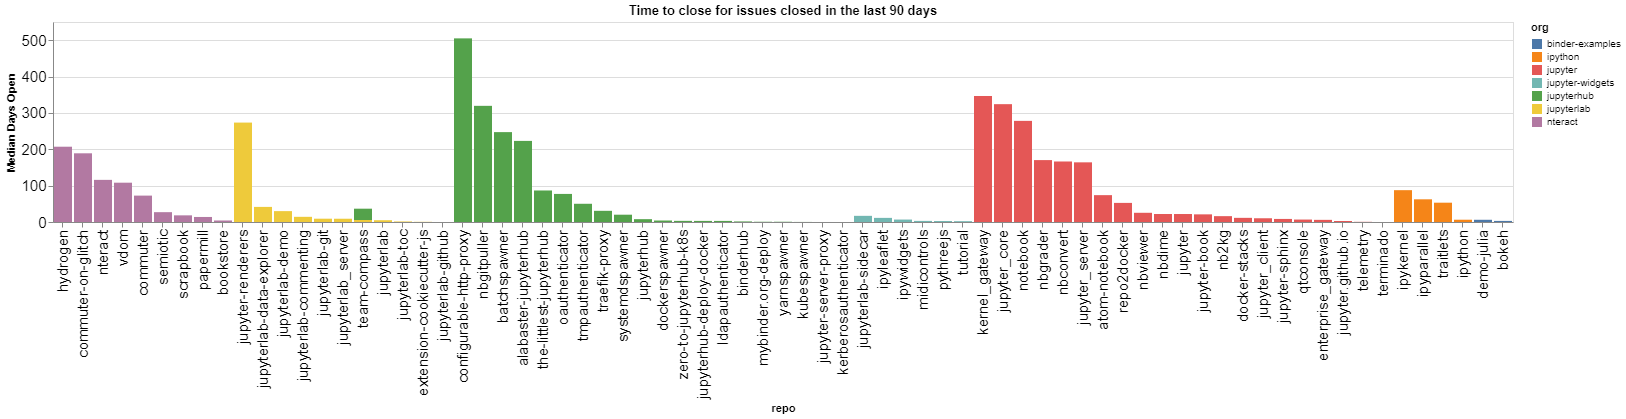

In [24]:
time_open = closed.groupby(['org', 'repo']).agg({'time_open': 'median'}).reset_index()
time_open['time_open'] = time_open['time_open'] / (60 * 60 * 24)
time_open['org/repo'] = time_open.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = time_open.sort_values(['org', 'time_open'], ascending=False)['repo'].values
alt.Chart(data=time_open, title=f"Time to close for issues closed in the last {n_days} days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y=alt.Y('time_open', title="Median Days Open"),
    color='org',
)

### A list of recent issues

Below is a list of issues with recent activity in each repository. If they seem of interest
to you, click on their links and jump in to participate!

In [25]:
# Add comment count data to issues and PRs
comment_counts = (
    comments
    .query("createdAt > @start_date and createdAt < @end_date")
    .groupby(['org', 'repo', 'issue_id'])
    .count().iloc[:, 0].to_frame()
)
comment_counts.columns = ['n_comments']
comment_counts = comment_counts.reset_index()

In [26]:
n_plot = 5
tabs = widgets.Tab(children=[])
for ii, (org, idata) in enumerate(comment_counts.groupby('org')):
    issue_md = []
    issue_md.append(f"#### {org}")
    issue_md.append("")
    for repo, i_issues in idata.groupby('repo'):
        issue_md.append(f"##### [{org}/{repo}](https://github.com/{org}/{repo})")

        top_issues = i_issues.sort_values('n_comments', ascending=False).head(n_plot)
        top_issue_list = pd.merge(issues, top_issues, left_on=['org', 'repo', 'number'], right_on=['org', 'repo', 'issue_id'])
        for _, issue in top_issue_list.sort_values('n_comments', ascending=False).head(n_plot).iterrows():
            user_name = issue['author']
            user_url = author_url(user_name)
            issue_number = issue['number']
            issue_html = issue['url']
            issue_title = issue['title']

            text = f"* [(#{issue_number})]({issue_html}): _{issue_title}_ by **[@{user_name}]({user_url})**"
            issue_md.append(text)

    issue_md.append('')
    md_html = HTML(markdown('\n'.join(issue_md)))
    
    children = list(tabs.children)
    children.append(HTML(markdown('\n'.join(issue_md))))
    tabs.children = tuple(children)
    tabs.set_title(ii, org)
    
display(Markdown(f"Here are the top {n_plot} active issues in each repository in the last {n_days} days"))
display(tabs)

Here are the top 5 active issues in each repository in the last 90 days

## Commenters across repositories

These are commenters across all issues and pull requests in the last several days.
These are colored by the commenter's association with the organization. For information
about what these associations mean, [see this StackOverflow post](https://stackoverflow.com/a/28866914/1927102).

In [27]:
commentors = (
    comments
    .query("createdAt > @start_date and createdAt < @end_date")
    .groupby(['org', 'repo', 'author', 'authorAssociation'])
    .count().rename(columns={'id': 'count'})['count']
    .reset_index()
    .sort_values(['org', 'count'], ascending=False)
)

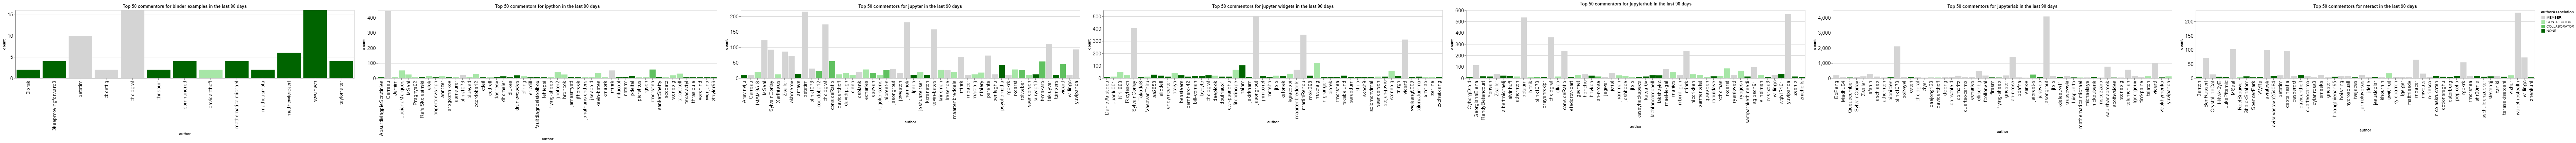

In [28]:
n_plot = 50
charts = []
for ii, (iorg, idata) in enumerate(commentors.groupby(['org'])):
    title = f"Top {n_plot} commentors for {iorg} in the last {n_days} days"
    idata = idata.groupby('author', as_index=False).agg({'count': 'sum', 'authorAssociation': 'first'})
    idata = idata.sort_values('count', ascending=False).head(n_plot)
    ch = alt.Chart(data=idata.head(n_plot), width=1000, title=title).mark_bar().encode(
        x='author',
        y='count',
        color=alt.Color('authorAssociation', scale=alt.Scale(domain=author_types, range=author_colors))
    )
    charts.append(ch)
alt.hconcat(*charts)

## First responders

First responders are the first people to respond to a new issue in one of the repositories.
The following plots show first responders for recently-created issues.

In [29]:
first_comments = []
for (org, repo, issue_id), i_comments in comments.groupby(['org', 'repo', 'issue_id']):
    ix_min = pd.to_datetime(i_comments['createdAt']).idxmin()
    first_comment = i_comments.loc[ix_min]
    if isinstance(first_comment, pd.DataFrame):
        first_comment = first_comment.iloc[0]
    first_comments.append(first_comment)
first_comments = pd.concat(first_comments, axis=1).T

In [30]:
first_responder_counts = first_comments.groupby(['org', 'author', 'authorAssociation'], as_index=False).\
    count().rename(columns={'id': 'n_first_responses'}).sort_values(['org', 'n_first_responses'], ascending=False)


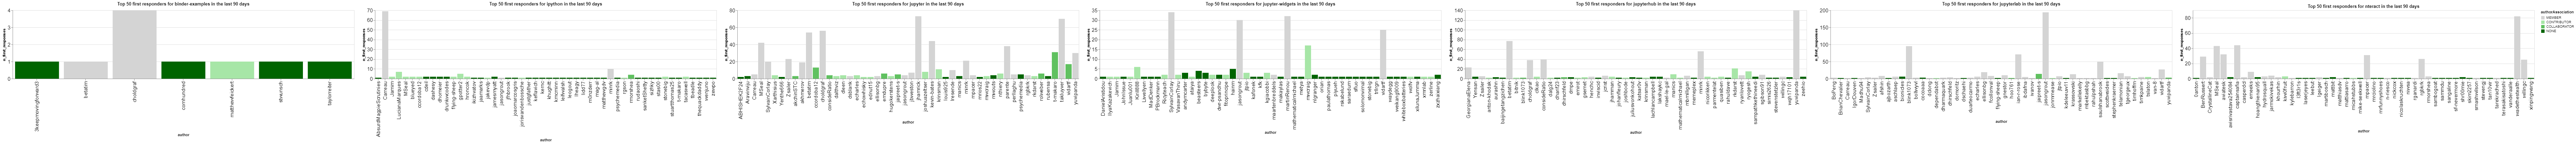

In [31]:
n_plot = 50
charts = []
for ii, (iorg, idata) in enumerate(first_responder_counts.groupby(['org'])):
    title = f"Top {n_plot} first responders for {iorg} in the last {n_days} days"
    idata = idata.groupby('author', as_index=False).agg({'n_first_responses': 'sum', 'authorAssociation': 'first'})
    idata = idata.sort_values('n_first_responses', ascending=False).head(n_plot)
    ch = alt.Chart(data=idata.head(n_plot), width=1000, title=title).mark_bar().encode(
        x='author',
        y='n_first_responses',
        color=alt.Color('authorAssociation', scale=alt.Scale(domain=author_types, range=author_colors))
    )
    charts.append(ch)
alt.hconcat(*charts)

In [32]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>